In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy
import random

In [4]:
# open and read in csv values
file = open("./qog_bas_ts_jan20.csv")
rows = file.read().split("\n")
file.close()

# find index of csv values i'm interested in
for row in rows:
    value = row.split(',')
    for i in range(len(value)):
            if value[i]=='gle_cgdpc':
                print(i, 'gle_cgdpc')
            if value[i]=='bl_asymf':
                print(i, 'bl_asymf')
            if value[i]=='gpi_gpi':
                print(i, 'gpi_gpi')
            if value[i]=='undp_hdi':
                print(i, 'undp_hdi')
            if value[i]=='bci_bci':
                print(i, 'bci_bci')
    break

27 bci_bci
32 bl_asymf
105 gle_cgdpc
116 gpi_gpi
181 undp_hdi


In [27]:
# initialize array to hold X and Y initially
hdi = numpy.zeros((15616,1))   
vars = numpy.zeros((15616,4))

# loop through dataset and add values to arrays where not null
i = 0
k = 0
for row in rows[1:15615]:
    j = 0
    value = row.split(',')
    k+=1
    if (len(value) == 289):
        value[1] = value[1] + value[2]
        value[5] = value[5] + value[6]
        value.pop(6)
        value.pop(2)
    if (value[181] == '' or value[105] == '' or value[116] == '' or value[32] == ''):
        continue
    hdi[i][0] = float(value[181])
    vars[i][j] = float(value[27])
    j+=1
    vars[i][j] = float(value[105])
    j+=1
    vars[i][j] = float(value[116])
    j+=1
    vars[i][j] = float(value[32])
    i+=1
    
# remove unset rows and standardize variables
hdi2 = hdi[0:i]
vars2 = vars[0:i,:]
vars2[:,0]=(vars2[:,0]-numpy.mean(vars2[:,0]))/(numpy.std(vars2[:,0]))
vars2[:,1]=(vars2[:,1]-numpy.mean(vars2[:,1]))/numpy.std(vars2[:,1])
vars2[:,2]=(vars2[:,2]-numpy.mean(vars2[:,2]))/numpy.std(vars2[:,2])
vars2[:,3]=(vars2[:,3]-numpy.mean(vars2[:,3]))/numpy.std(vars2[:,3])
hdi2std=numpy.std(hdi2)
hdi2mean=numpy.mean(hdi2)
hdi2=(hdi2-numpy.mean(hdi2))/numpy.std(hdi2)

In [33]:
# set random seed and generate random indices for training/testing split
random.seed(216)
sequence = [k for k in range(len(hdi2))]
test = random.sample(sequence,30)

hditest = []
vartest = []
hditrain = []
vartrain = []
    

for k in range(len(hdi2)):
    if (k in test):
        hditest.append(hdi2[k])
        vartest.append(vars2[k])
    else:
        hditrain.append(hdi2[k])
        vartrain.append(vars2[k])
                

In [34]:
hditest = numpy.asarray(hditest)
hditrain = numpy.asarray(hditrain)
vartest = numpy.asarray(vartest)
varstrain = numpy.asarray(vartrain)

In [35]:
# function to return betas given x,y,lambdas for linear regression with ridge penalty
def solve_ridgelinear_regression(X,Y, lambdas):
    N = len(Y)
    X1 = numpy.hstack((numpy.ones((N,1)),X))
    lams = numpy.diagflat(numpy.ones(X1.shape[1])) * lambdas
    lams[0,0] = 0
    betas = numpy.dot(numpy.linalg.inv(numpy.dot(X1.transpose(),X1)+lams),numpy.dot(X1.transpose(),Y))  
    return betas

In [37]:
# loop over 25 different possible lambda values
minerror = 100
minlambda = 0
vars21 = numpy.concatenate((numpy.ones((1,vartest.shape[0])).T,vartest),axis=1)
for i in range(25):  
    betas_mle = solve_ridgelinear_regression(varstrain,hditrain,i)

    if (numpy.sqrt(numpy.mean((hditest-numpy.dot(vars21,betas_mle))**2))) < minerror:
        minerror = (numpy.sqrt(numpy.mean((hditest-numpy.dot(vars21,betas_mle))**2)))
        minlambda = i
        
# print out lambda and smallest error
betas_mle_exact2 = solve_ridgelinear_regression(vars2,hdi2,minlambda)
print(minlambda, minerror)

12 0.43329442101270105


Text(0, 0.5, 'Predicted')

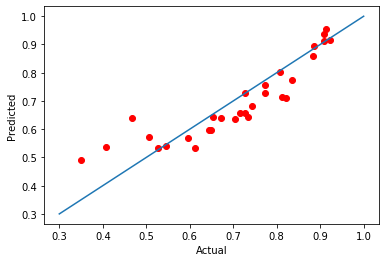

In [40]:
plt.plot((hditest*hdi2std + hdi2mean)[:,0],numpy.dot(vars21,betas_mle_exact2)*hdi2std + hdi2mean, 'ro')
plt.plot([0.3,1],[0.3,1])
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [41]:
print(betas_mle_exact2)

[[-2.94153769e-16]
 [-1.63077034e-01]
 [ 2.18191699e-01]
 [-2.20504413e-02]
 [ 6.13149293e-01]]
